# Teste Modelo aclopado

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.integrate import odeint
import lmfit
from lmfit.lineshapes import gaussian, lorentzian
import warnings
import modelos_epidemiologicos as model #

### leitura dos dados

In [2]:
df0= pd.read_parquet("/home/akel/PycharmProjects/Endemic_model/brainstorms/caso_full.parquet")
df0['date']=pd.to_datetime(df0['date'],format='%Y-%m-%d')
dfbel= df0[(df0["city"] == "Belém") & (df0['state']=='PA') ]

### Visualização previa

1

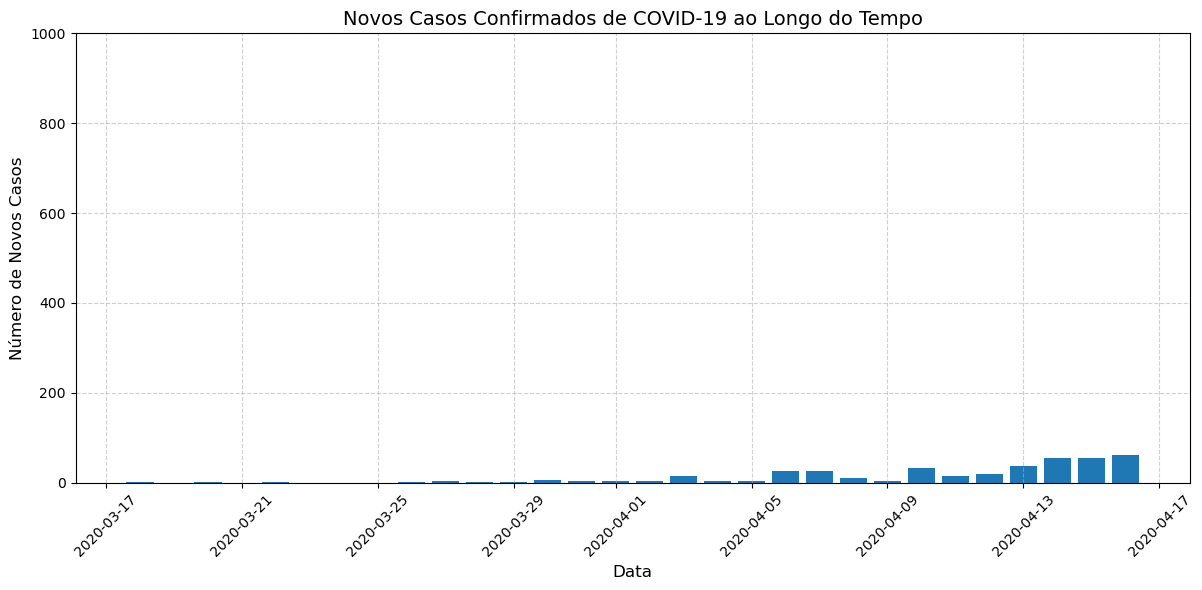

In [28]:
nd=30
dfbel['new_confirmed'].iloc[0:nd];
dfbel['date'].iloc[0:nd];
plt.figure(figsize=(12, 6))  # Tamanho do gráfico

plt.bar(dfbel['date'].iloc[0:nd],dfbel['new_confirmed'].iloc[0:nd])

# Formatação do gráfico
plt.title('Novos Casos Confirmados de COVID-19 ao Longo do Tempo', fontsize=14)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Número de Novos Casos', fontsize=12)
plt.xticks(rotation=45)  # Rotaciona as datas para melhor legibilidade
plt.grid(True, linestyle='--', alpha=0.6)  # Adiciona grid
plt.tight_layout()
plt.ylim([0,1000])

c=dfbel['new_confirmed'].iloc[0:nd]
#t_data = np.arange(0, 30)
c = np.array([10, 30, 80, 180, 380, 780, 1580, 2780, 4380, 6380, 
                  8780, 11580, 14680, 17980, 21380, 24830, 28310, 31790, 
                  35190, 38510, 41740, 44870, 47890, 50800, 53590, 56260, 58810, 61240, 63550, 65740])
c2=np.diff(c)
c2=[[0,c2]]
len(c2)

In [19]:
def model_sir(t, N, R, beta,gamma):
    y0 = N-15, 15, R
    out = odeint(model.SIR, y0, t, args=(N, beta, gamma))
    S, I, R = out.T
    return I
    
mod = lmfit.Model(model_sir)


mod.set_param_hint("N", value=50, vary=True) #
mod.set_param_hint("R", value=1, vary=True) #
mod.set_param_hint("beta", value=1, vary=True) #
mod.set_param_hint("gamma", value=1, vary=True) #


#estimador de paramentros
params = mod.make_params()

#parametros do modelo
t=np.linspace(0,nd-1,nd)
out = mod.fit(c, params, t=t)  
N1=out.values['N']
R1=out.values['R']
beta1=out.values['beta']
gamma1=out.values['gamma']

/tmp/ipykernel_971532/3408544000.py:3: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  out = odeint(model.SIR, y0, t, args=(N, beta, gamma))


In [5]:
# c=dfbel['new_confirmed'].iloc[0:120]
# t=np.linspace(0,119,120)
# print(c.size)

In [10]:
beta1=out.values['beta']


[[Model]]
    Model(model_sir)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 68
    # data points      = 30
    # variables        = 3
    chi-square         = 99567794.7
    reduced chi-square = 3687696.10
    Akaike info crit   = 456.454558
    Bayesian info crit = 460.658150
    R-squared          = 0.99363545
[[Variables]]
    N:      100000 (fixed)
    beta:   0.26007613 +/- 0.01195416 (4.60%) (init = 0.2)
    gamma:  0.03175620 +/- 0.00278722 (8.78%) (init = 0.1)
    I0:     999.999987 +/- 239.163117 (23.92%) (init = 15)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, I0)    = +0.9511
    C(beta, gamma) = +0.9086
    C(gamma, I0)   = +0.7669


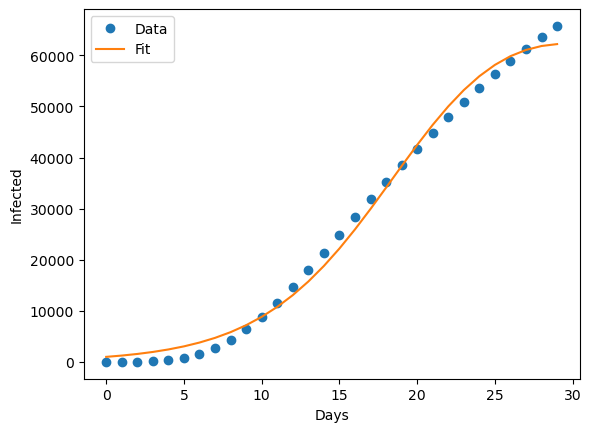

In [20]:
# Define the SIR model differential equations
def sir_model(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return [dSdt, dIdt, dRdt]

# Wrapper function for lmfit
def model_sir(t, N, beta, gamma, I0):
    # Initial conditions: S0 = N-I0, I0, R0=0
    y0 = [N-I0, I0, 0]
    out = odeint(sir_model, y0, t, args=(N, beta, gamma))
    S, I, R = out.T
    return I

# Create lmfit model
mod = lmfit.Model(model_sir)

# Set parameter hints with realistic bounds
#mod.set_param_hint("N", value=10000, min=nd/2, max=1e6)  # Total population
mod.set_param_hint("N",value= 100000, vary=False)  # Total population
mod.set_param_hint("beta", value=0.2, min=0.001, max=2)  # Infection rate
mod.set_param_hint("gamma", value=0.1, min=0.001, max=1)  # Recovery rate
mod.set_param_hint("I0", value=15, min=1, max=1000)  # Initial infected

# Create parameters
params = mod.make_params()

# Time points (days)
t = np.linspace(0, nd-1, nd)

# Fit the model to your data (replace 'c' with your actual case data)
result = mod.fit(c, params, method="leastsq", t=t)

# Print the fit report
print(result.fit_report())

# Plot results
import matplotlib.pyplot as plt
plt.plot(t, c, 'o', label='Data')
plt.plot(t, result.best_fit, '-', label='Fit')
plt.xlabel('Days')
plt.ylabel('Infected')
plt.legend()
plt.show()